In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus'] = False

## LSTM 모델을 사용한 날씨 예측
- Forcast a multivariate time series
- 다중변수(온도, 대기압 및 공기 밀도)로 일정기간의 온도 예측

In [2]:
zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract = True
)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

C:\Users\서지희\.keras\datasets\jena_climate_2009_2016.csv


In [3]:
#panas dataframe으로 csv 파일 read
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## 3개의 특징만 추출

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

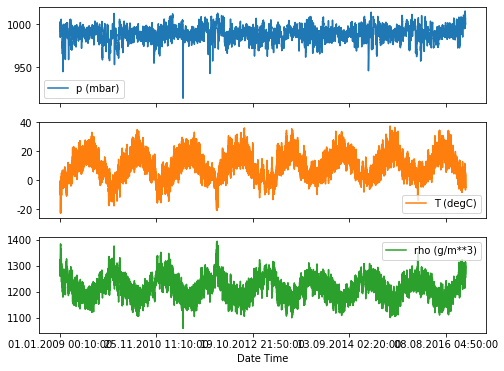

In [5]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index= df['Date Time']
features.head()

features.plot(subplots = True)

In [6]:
TRAIN_SPLIT= 300000
tf.random.set_seed(13)

In [7]:
def create_time_steps(length):
    return list(range(-length, 0))

In [8]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize = 10,
                     label = labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) *2])
    plt.xlabel('Time-Step')
    return plt

## 표준화

In [9]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)

dataset = (dataset-data_mean)/data_std

## Multi-Step model
다단계 예측 모델은 과거 히스토리로 미래의 값 범위를 예측하는 방법으로 미래 시퀀스를 예측
5일동안의 기록을 이용하여 12시간 동안의 온도를 예측

In [10]:
def multivariable_data(dataset, target, start_index, end_index, history_size,
                       target_size, step, single_step=False):
    data= []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

## 데이터 윈도우 추출
5일동안의 기록을 이용하여 12시간의 온도를 예측
10분 단위로 관측된 값이므로 한시간에 6개, 하루에 144(6*24)개 관측값
window 추출
- x: 지난 5일의 온도 관측값 720(5*144)
- step: 이동단위 1시간,6
- y: 12시간동안의 미래값 예측값 72(12*6)

In [11]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariable_data(dataset, dataset[:, 1], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP, single_step=False)
x_val_multi, y_val_multi = multivariable_data(dataset, dataset[:,1],
                                              TRAIN_SPLIT, None, past_history,
                                              future_target, STEP, single_step=False)

In [12]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\nTarget temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

Target temperature to predict : (72,)


## LSTM 데이터 입력 구조로 학습데이터, 테스트 데이터 추출

In [13]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 다단계 예측 모델 Plotting

In [14]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:,1]), label = 'History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label = 'True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label = 'Predicted Future')
    plt.legend(loc = 'upper left')
    plt.show()

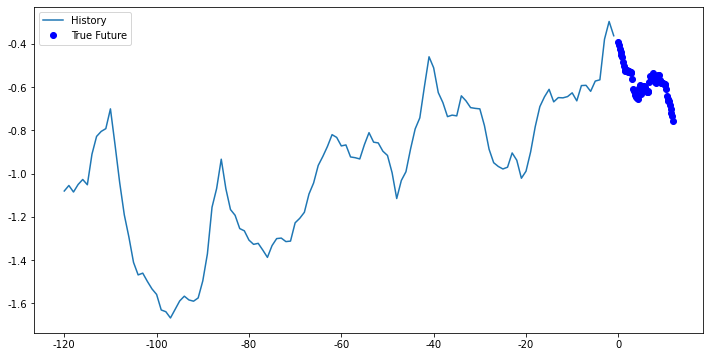

In [15]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

## 모델 구성

다단계 예측모델은 이전 작업보다 약간 복잡하기 때문에 두 개의 LSTM 계층으로 구성
마지막 layer에서는 72개의 예측을 출력

In [16]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [17]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [49]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 44s 213ms/step - loss: 0.6823 - val_loss: 0.3212

In [19]:
print(x_train_multi.shape[-2:])
print(x_train_multi)

(120, 3)
[[[ 0.95547359 -1.99766294  2.2350791 ]
  [ 0.95304508 -1.95134907  2.18442875]
  [ 0.96883036 -2.09376424  2.34176293]
  ...
  [ 0.9627591  -2.26396773  2.52919369]
  [ 1.0186147  -2.3125973   2.59672749]
  [ 1.06475628 -2.45385463  2.76164698]]

 [[ 0.96154485 -2.04281897  2.28524007]
  [ 0.95304508 -1.95134907  2.18467344]
  [ 0.98218713 -2.09144854  2.34274168]
  ...
  [ 0.97854438 -2.27438836  2.54460901]
  [ 1.02711446 -2.32880716  2.61654719]
  [ 1.07568454 -2.47701156  2.78978607]]

 [[ 0.95668784 -2.05439744  2.29600633]
  [ 0.95304508 -1.98492663  2.22088721]
  [ 0.9906869  -2.07176515  2.32365604]
  ...
  [ 0.98704414 -2.2778619   2.55097089]
  [ 1.02954297 -2.35312194  2.64321815]
  [ 1.0793273  -2.49322142  2.80813764]]

 ...

 [[ 0.12978217  0.88884939 -0.88615693]
  [ 0.11156839  0.87842877 -0.88126317]
  [ 0.08242634  0.88190231 -0.89178474]
  ...
  [ 0.47584401  0.68391049 -0.60696829]
  [ 0.52198559  0.66770064 -0.57956327]
  [ 0.54869914  0.65612217 -0.56219

## 학습결과 플로팅

In [50]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

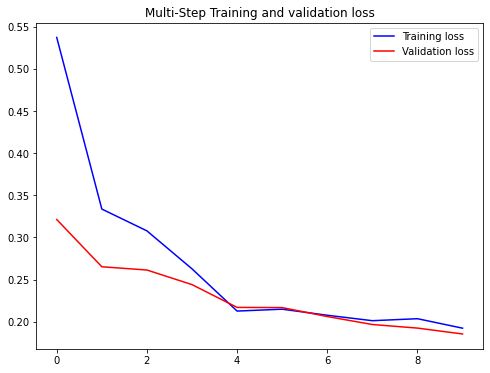

In [51]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Predict a multi-step future
학습된 모델을 이용한 다단계 예측

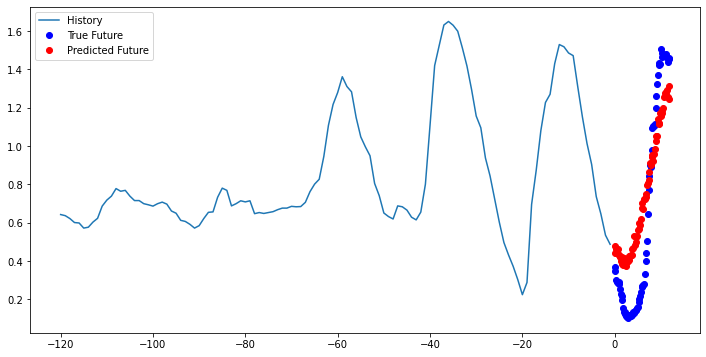

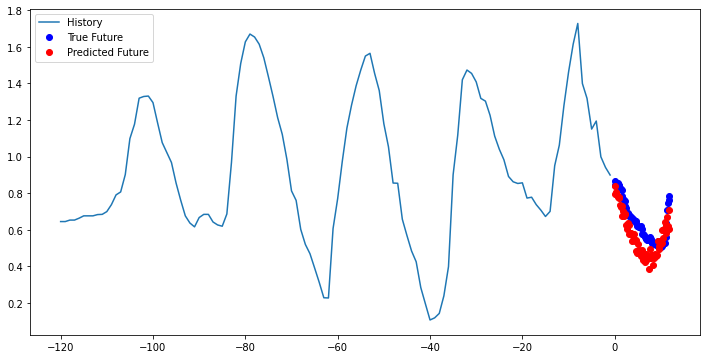

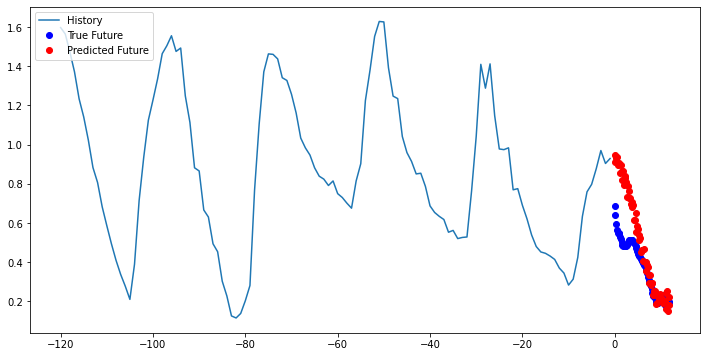

In [52]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## 모델 평가하기

In [53]:
trainScore = multi_step_model.evaluate(x_train_multi, y_train_multi, verbose=0)
print('Train Score: ', trainScore)
valScore = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=0)
print('Validation Score: ', valScore)

Train Score:  0.19773492217063904
Validation Score:  0.19747592508792877
